<a href="https://colab.research.google.com/github/Ankesh2004/Git_demo/blob/master/Lungs_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. basic imports

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# training data directory
X_Ray_Directory = '/content/drive/My Drive/Dataset/train'

In [ ]:
os.listdir(X_Ray_Directory)


['Covid-19', 'Viral_Pneumonia', 'Bacterial_Pneumonia', 'Normal']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size= 40, directory = X_Ray_Directory, shuffle = True, target_size =(256,256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [ ]:
#checking indices
print(train_generator.class_indices)

{'Bacterial_Pneumonia': 0, 'Covid-19': 1, 'Normal': 2, 'Viral_Pneumonia': 3}


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size= 40, directory = X_Ray_Directory, shuffle = True, target_size =(256,256), class_mode = 'categorical', subset = 'validation')


Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]],

In [ ]:
# labels Translator
label_names = {
    0: 'Bacterial_Pneumonia',
    1: 'Covid-19',
    2: 'Normal',
    3: 'Viral_Pneumonia'
}

Visualize dataset

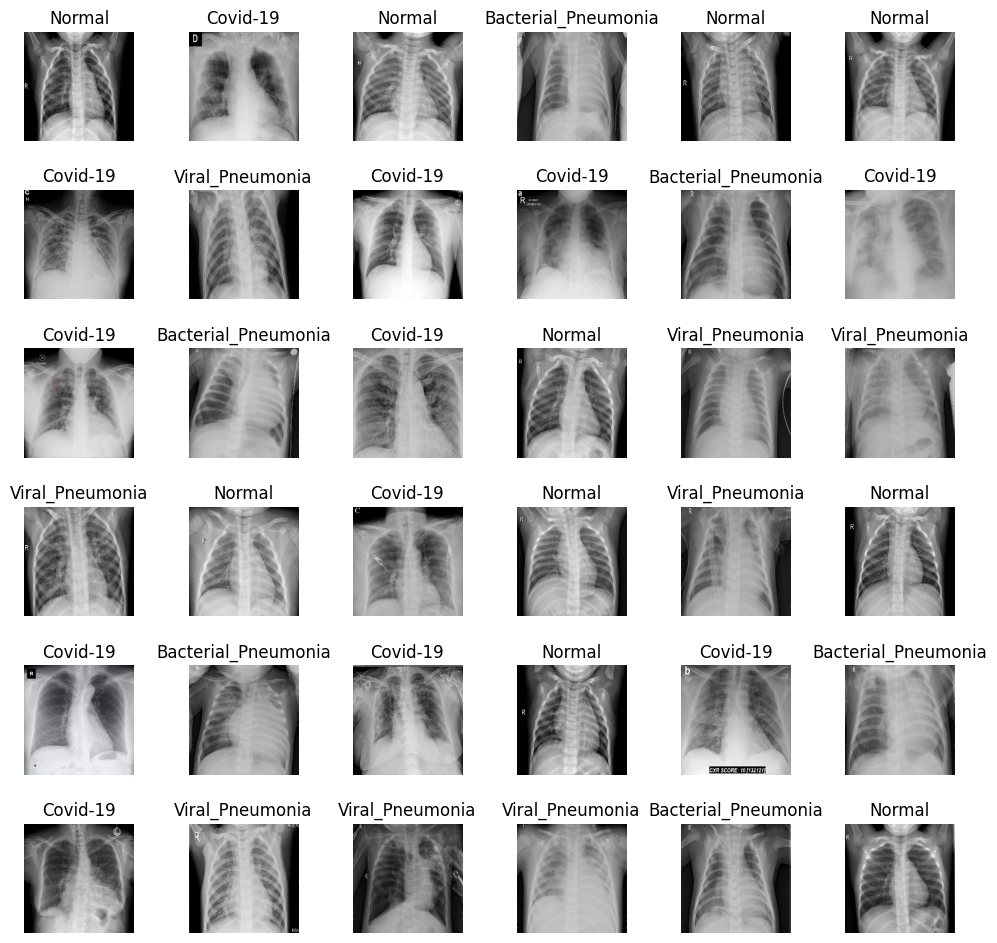

In [ ]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

IMPORT MODEL WITH PRETRAINED WEIGHTS

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
basemodel.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten (name = 'flatten') (headmodel)
headmodel = Dense(256, activation = 'relu') (headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu') (headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax') (headmodel)

In [ ]:
model = Model(inputs = basemodel.input, outputs = headmodel)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])


In [ ]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdtf5.keras', verbose = 1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'training')
validation_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'validation')


Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit(
    train_generator,  # Training data generator
    epochs=50,  # Number of epochs to train
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpointer, earlystopping]  # Callbacks for saving the model and early stopping
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_364']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5672 - loss: 1.2309
Epoch 1: val_loss improved from inf to 3.66094, saving model to weights.hdtf5.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - accuracy: 0.5683 - loss: 1.2278 - val_accuracy: 0.2500 - val_loss: 3.6609
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8441 - loss: 0.4350
Epoch 2: val_loss improved from 3.66094 to 3.52776, saving model to weights.hdtf5.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.8441 - loss: 0.4352 - val_accuracy: 0.2115 - val_loss: 3.5278
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9551 - loss: 0.1504
Epoch 3: val_loss did not improve from 3.52776
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9549 - loss: 0.1511 - val_accuracy: 0.2500 - val_loss: 5.6092
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9352 - loss: 0.2007
Epoch 4: val_loss did not improve from 3.52776
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 102m

EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0, 0.5, 'Training Accuracy and Loss')

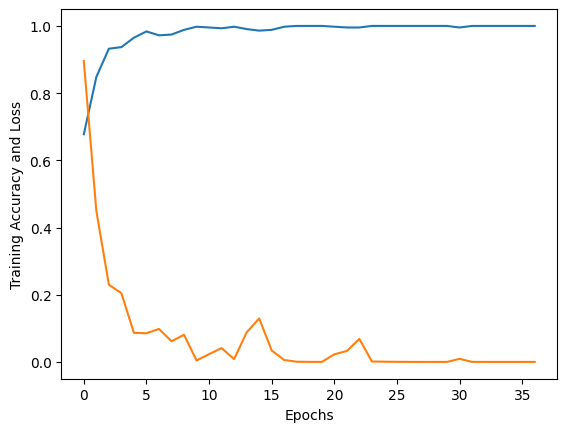

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy and Loss')


Text(0, 0.5, 'Validation Loss')

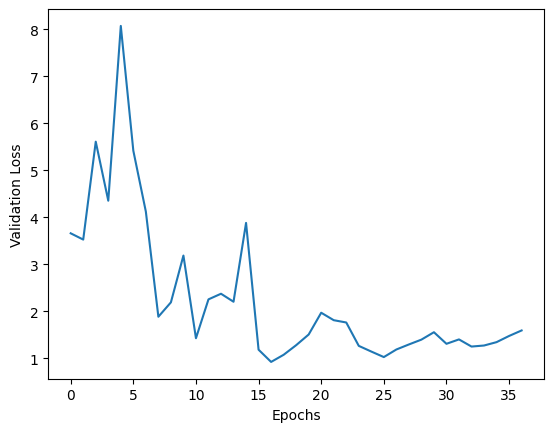

In [ ]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

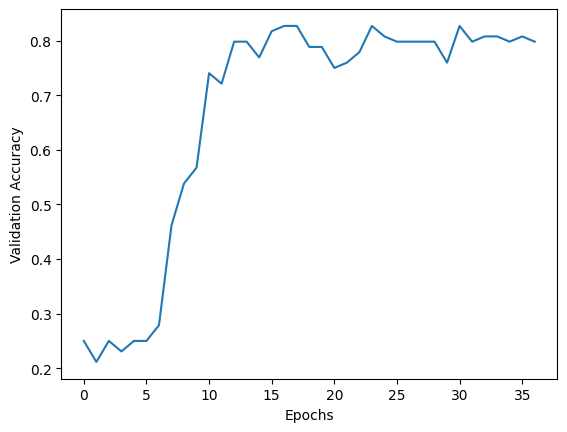

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [ ]:
# saving trained model to drive
model.save('/content/drive/My Drive/my_model.keras')

In [ ]:
test_directory = ('/content/drive/My Drive/Dataset/test')


In [ ]:
#checking model's accuracy
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical')
evaluate = model.evaluate(test_generator, steps = test_generator.n//4, verbose = 1)
print('Accuracy Test : {}'.format(evaluate[1]))

Found 741 images belonging to 4 classes.
185/185 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.8840 - loss: 3.0942  
Accuracy Test : 0.8825910687446594


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Define the mapping from directory names to labels
label_names = {
    'Bacterial_Pneumonia': 0,
    'Covid-19': 1,
    'Normal': 2,
    'Viral_Pneumonia': 3
}

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import os
import cv2

prediction = []  # To store model predictions
original = []    # To store original labels

# Iterate through the test directory
for class_name in os.listdir(test_directory):
    class_dir = os.path.join(test_directory, class_name)
    if not os.path.isdir(class_dir):
        continue  # Skip if it's not a directory

    # Get the label for the current class
    label = label_names.get(class_name, -1)  # Default to -1 if class_name is not found
    if label == -1:
        print(f"Warning: Unknown class '{class_name}' in test directory. Skipping.")
        continue

    # Iterate through images in the class directory
    for item in os.listdir(class_dir):
        # Load and preprocess the image
        img = cv2.imread(os.path.join(class_dir, item))
        img = cv2.resize(img, (256, 256))  # Resize image to 256x256
        img = img / 255.0  # Normalize pixel values to [0, 1]
        img = img.reshape(-1, 256, 256, 3)  # Reshape for model input

        # Make a prediction
        predict = model.predict(img)
        predict = np.argmax(predict)  # Get the predicted class index
        prediction.append(predict)    # Store the prediction
        original.append(label)        # Store the original label

# Evaluate the model
conf_matrix = confusion_matrix(original, prediction)
class_report = classification_report(original, prediction, target_names=label_names.keys())
accuracy = accuracy_score(original, prediction)

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print('Accuracy:', accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_364']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

In [ ]:
len(original)


741

In [ ]:
score = accuracy_score(original, prediction)
print('Test Accuracy: {}'.format(score))

Test Accuracy: 0.8839406207827261


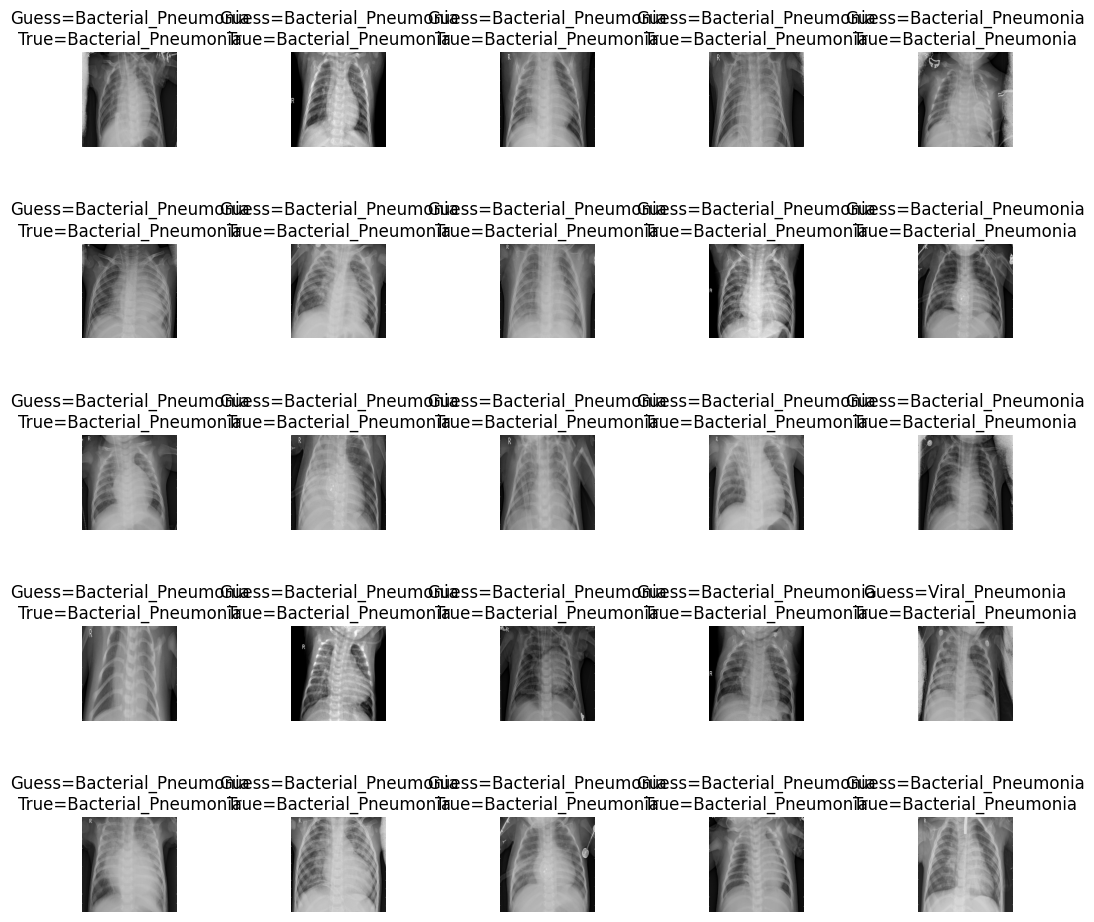

In [ ]:
# Reverse the label_names dictionary to map integer labels to class names
label_names = {
    0: 'Bacterial_Pneumonia',
    1: 'Covid-19',
    2: 'Normal',
    3: 'Viral_Pneumonia'
}

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(
        label_names[prediction[i]],  # Use integer label as key
        label_names[original[i]]     # Use integer label as key
    ))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1.2)
plt.show()

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       231
           1       0.92      0.97      0.94       116
           2       0.95      0.89      0.92       317
           3       0.58      0.84      0.68        77

    accuracy                           0.88       741
   macro avg       0.84      0.89      0.86       741
weighted avg       0.90      0.88      0.89       741



Text(0.5, 1.0, 'Confusion_matrix')

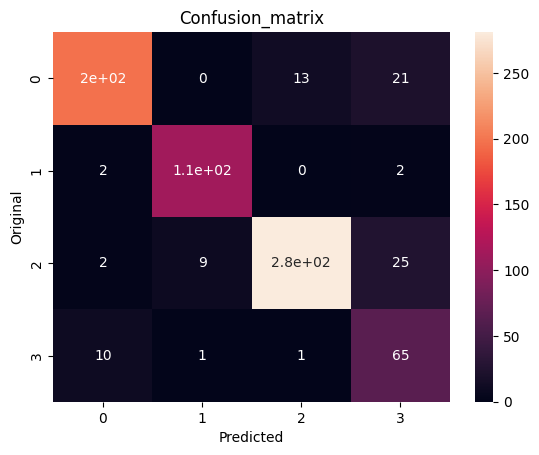

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')